## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import DATA_DIR, FIG_DIR, RAW_DIR, STOP_WORDS
from khan_helpers.functions import (
    corr_mean,
    format_text, 
    interp_lecture, 
    parse_windows,
    r2z,
    show_source,
    symmetric_kl,
    z2r,
    _ts_to_sec
)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.helpers import show_source<br />    show_source(foo)</pre>

## Load data

In [2]:
exp = Experiment()

# lecture transcripts
ff_transcript, bos_transcript = exp.load_transcript(('forces', 'bos'))

# questions
questions_df = exp.load_questions()

# participants' quiz scores
participants = []
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), sep='\t', index_col='Unnamed: 0')
for ix, row in raw_data.iterrows():
    p = Participant.from_psiturk(row, subid=f"P{ix + 1}")
    participants.append(p)

## Define/inspect some functions

In [3]:
show_source(format_text)

In [4]:
show_source(parse_windows)

In [5]:
show_source(_ts_to_sec)

In [6]:
show_source(interp_lecture)

In [7]:
def create_qa_corpus(corpus_key):
    # subset of text used to fit model
    corpus_text = qa_text.copy()
    
    if 'q' in corpus_key:
        corpus_text['gen_qs'] = []
        corpus_text['gen_ans'] = []
    elif 'q' not in corpus_key.lower():
        corpus_text['ff_qs'] = []
        corpus_text['bos_qs'] = []
        corpus_text['gen_qs'] = []
    
    if 'a' in corpus_key:
        corpus_text['ff_ans'] = ff_correct
        corpus_text['bos_ans'] = bos_correct
        if 'Q' in corpus_key:
            corpus_text['gen_ans'] = gen_correct
    elif 'a' not in corpus_key.lower():
        corpus_text['ff_ans'] = []
        corpus_text['bos_ans'] = []
        corpus_text['gen_ans'] = []
        
    return corpus_text

In [8]:
def model_content(n_top, wsize, corpus_key):
    # get text windows, timestamps
    ff_windows, ff_timestamps = parse_windows(ff_transcript, wsize)
    bos_windows, bos_timestamps = parse_windows(bos_transcript, wsize)
    
    # local copy of text corpus for adding param-dependent lecture windows
    all_text = qa_text.copy()
    
    # format lecture, question, answer text
    ff_lec = format_text(ff_windows)
    bos_lec = format_text(bos_windows)
    corpus_text = create_qa_corpus(corpus_key)
    corpus_text['ff_lec'] = all_text['ff_lec'] = ff_lec
    corpus_text['bos_lec'] = all_text['bos_lec'] = bos_lec

    # set topic model params
    tm_params = lda_params.copy()
    tm_params['n_components'] = n_top
    
    full_corpus = [doc for samples in corpus_text.values() for doc in samples]
    
    # only bother transforming data used for scoring models
    vecs = dict.fromkeys(('ff_lec', 'bos_lec', 'ff_qs', 'bos_qs'))
    
    # fit CountVectorizer model
    tf_vectorizer = CountVectorizer(**cv_params)
    tf_vectorizer.fit(full_corpus)
    
    # transform lectures, questions, answers
    for samples in vecs.keys():
        vecs[samples] = tf_vectorizer.transform(all_text[samples])
        
    vecs['full_corpus'] = tf_vectorizer.transform(full_corpus)

    trajs = {}
    # fit LDA model
    topic_model = LatentDirichletAllocation(**tm_params)
    topic_model.fit(vecs['full_corpus'])
    
    # transform word count matrices
    for samples, doc_vecs in vecs.items():
        trajs[samples] = topic_model.transform(doc_vecs)
            
    # interpolate lectures to 1 sample per second
    trajs['ff_lec'] = interp_lecture(trajs['ff_lec'], ff_timestamps)
    trajs['bos_lec'] = interp_lecture(trajs['bos_lec'], bos_timestamps)

    return trajs

In [9]:
show_source(r2z)

In [10]:
show_source(z2r)

In [11]:
show_source(corr_mean)

In [12]:
show_source(symmetric_kl)

In [13]:
def reconstruct_trace(video_model, questions_model, acc):
    acc = np.array(acc, dtype=bool)
    wz = 1 - cdist(video_model, questions_model, metric=symmetric_kl)
    wz -= np.min(wz)
    wz /= np.max(wz)
    a = wz.sum(axis=1)
    b = wz[:, acc].sum(axis=1)
    return b / a

In [14]:
def score_params(traj_dict):
    ff_lec = traj_dict['ff_lec']
    bos_lec = traj_dict['bos_lec']
    ff_bos_questions = np.concatenate((traj_dict['ff_qs'], traj_dict['bos_qs']))
    corrs = []
    for lec_ix, lec in enumerate([ff_lec, bos_lec], start=1):
        p_correct = []
        trace_sums = []
        for sub in participants:
            sub_scores = sub.get_data(qset=lec_ix, lecture=lec_ix)
            # compute proportion correct
            sub_acc = sub_scores['accuracy'].tolist()
            sub_pc = sum(sub_acc) / len(sub_acc)
            p_correct.append(sub_pc)
            # reconstruct trace
            qs_ix = sub_scores['qID'] - 1
            q_vecs = ff_bos_questions[qs_ix]
            sub_trace = reconstruct_trace(lec, q_vecs, sub_acc)
            trace_sums.append(sub_trace.sum())

        corrs.append(pearsonr(p_correct, trace_sums)[0])
    return corr_mean(corrs)

In [15]:
def grid_search(gs_params):
    n_top, wsize, corpus = gs_params
    trajs = model_content(n_top, wsize, corpus)
    corr = score_params(trajs)
    print(f'\t{gs_params} : {corr}')
    return corr

## Set static params

In [16]:
# CountVectorizer params
cv_params = {
    'strip_accents': 'unicode',
    'stop_words': STOP_WORDS,
}

# LatentDirichletAllocation params
lda_params = {
    'learning_method': 'batch',
    'random_state': 0
}

print(', '.join(STOP_WORDS))

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

## Pre-format question & answer text to save time

In [17]:
grouped_qs = questions_df.groupby('lecture')
gen_qs, ff_qs, bos_qs = grouped_qs['question'].apply(format_text)
answers_fmt = grouped_qs['A', 'B', 'C', 'D'].agg(format_text)
gen_correct, ff_correct, bos_correct = answers_fmt['A']
gen_ans, ff_ans, bos_ans = answers_fmt.apply(np.concatenate, axis=1).apply(list)
qa_text = {
    'ff_qs': ff_qs,
    'bos_qs': bos_qs,
    'gen_qs': gen_qs,
    'ff_ans': ff_ans,
    'bos_ans': bos_ans,
    'gen_ans': gen_ans
}

## Grid search params

In [18]:
# (maximum) number of topics to fit the topic model
n_topics = [5, 10, 15, 20, 30, 40, 50]

# length of lecture transcript sliding window
lecture_wsize = [5, 10, 15, 20, 30, 40, 50]

# training corpus for topic model
# - l: lecture sliding windows
# - q: lecture-related multiple choice questions' text
# - Q: all multiple choice questions' text
# - a: correct responses to multiple choice questions
# - A: all options for responses to multiple choice questions
corpora = ['l', 'lq', 'lQ', 'lqa', 'lQa', 'lqA', 'lQA']

param_grid = [(t, w, c) for t in n_topics for w in lecture_wsize for c in corpora]

In [19]:
param_scores = []
for params in tqdm(param_grid, desc='params', leave=True):
    result = grid_search(params)
    param_scores.append(result)

	(5, 5, 'l') : 0.991381627591752
	(5, 5, 'lq') : 0.9754302779881192
	(5, 5, 'lQ') : 0.9765994310694067
	(5, 5, 'lqa') : 0.9677030631353389
	(5, 5, 'lQa') : 0.9834872576000208
	(5, 5, 'lqA') : 0.9893736186130351
	(5, 5, 'lQA') : 0.9902638603058046
	(5, 10, 'l') : 0.9830752540647034
	(5, 10, 'lq') : 0.9730200494584019
	(5, 10, 'lQ') : 0.9805664802058897
	(5, 10, 'lqa') : 0.9825356707460257
	(5, 10, 'lQa') : 0.9857022466623733
	(5, 10, 'lqA') : 0.9819936223235821
	(5, 10, 'lQA') : 0.9850597582473231
	(5, 15, 'l') : 0.9851190045681844
	(5, 15, 'lq') : 0.9780044637338254
	(5, 15, 'lQ') : 0.9899118563873568
	(5, 15, 'lqa') : 0.9774278313992246
	(5, 15, 'lQa') : 0.9856446744369622
	(5, 15, 'lqA') : 0.9650556788194133
	(5, 15, 'lQA') : 0.9887401413040158
	(5, 20, 'l') : 0.9856255150714655
	(5, 20, 'lq') : 0.9794934037210253
	(5, 20, 'lQ') : 0.9868222465505974
	(5, 20, 'lqa') : 0.9770727211836706
	(5, 20, 'lQa') : 0.972227675086737
	(5, 20, 'lqA') : 0.9721891970970092
	(5, 20, 'lQA') : 0.991081

	(30, 20, 'lqA') : 0.9479006504747096
	(30, 20, 'lQA') : 0.9811204364409937
	(30, 30, 'l') : 0.9765434946226581
	(30, 30, 'lq') : 0.9653374246690112
	(30, 30, 'lQ') : 0.9601715799274403
	(30, 30, 'lqa') : 0.9628692287264112
	(30, 30, 'lQa') : 0.9389315791237541
	(30, 30, 'lqA') : 0.9504525838977369
	(30, 30, 'lQA') : 0.9783181956565754
	(30, 40, 'l') : 0.9772380439824084
	(30, 40, 'lq') : 0.959351596473264
	(30, 40, 'lQ') : 0.9321349817565441
	(30, 40, 'lqa') : 0.9533010985360593
	(30, 40, 'lQa') : 0.9569793375525429
	(30, 40, 'lqA') : 0.9634727120334843
	(30, 40, 'lQA') : 0.9709595543146031
	(30, 50, 'l') : 0.9787007126787807
	(30, 50, 'lq') : 0.9726770614803224
	(30, 50, 'lQ') : 0.9386798057677446
	(30, 50, 'lqa') : 0.9606610448883901
	(30, 50, 'lQa') : 0.9524167198795733
	(30, 50, 'lqA') : 0.9500470777301574
	(30, 50, 'lQA') : 0.950106822153431
	(40, 5, 'l') : 0.9789700893356467
	(40, 5, 'lq') : 0.9686619406625555
	(40, 5, 'lQ') : 0.9589253706474317
	(40, 5, 'lqa') : 0.9661559565528

In [20]:
# optimal number of topics, lecture window size, training corpus:
np.array(param_grid)[np.argmax(param_scores)]

array(['10', '20', 'lQA'], dtype='<U21')

In [21]:
gs_results = pd.DataFrame(param_grid, columns=['topics', 'wsize', 'corpus'])
gs_results['correlation'] = param_scores
gs_results.to_pickle(DATA_DIR.joinpath('grid_search_results.p'))

# gs_results = pd.read_pickle(DATA_DIR.joinpath('grid_search_results.p'))
# param_scores = gs_results['correlation'].tolist()

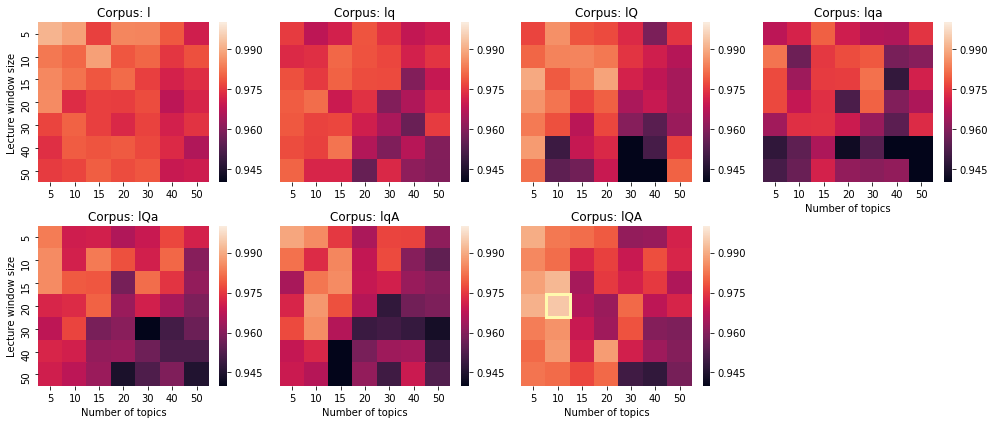

In [24]:
fig, axarr = plt.subplots(2, 4)
fig.set_size_inches(14, 6)
axarr = axarr.flatten()

param_arr = np.moveaxis(np.reshape(param_scores, (7, 7, 7)), 2, 0)
opt_params = np.unravel_index(param_arr.argmax(), param_arr.shape)
opt_corpus, opt_ntopics, opt_wsize = opt_params

for i, (ax, arr) in enumerate(zip(axarr, param_arr)):
    
    cb = True
    yt = lecture_wsize if i in [0, 4] else []
    ax = sns.heatmap(arr.T, vmin=.94, vmax=1, xticklabels=n_topics, yticklabels=yt, 
                     ax=ax, cbar=cb)
    ax.set_title(f'Corpus: {corpora[i]}')
    if i >= 3:
        ax.set_xlabel('Number of topics')
    if i in [0, 4]:
        ax.set_ylabel('Lecture window size')
        
    if i == opt_corpus:
        ax.add_patch(Rectangle((opt_ntopics, opt_wsize), 1, 1, fill=False, 
                               edgecolor='#FFF9AE', lw=3))
        
    
    
axarr[-1].axis('off')
plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('parameter_search.pdf'), bbox_inches='tight')
plt.show()